In [1]:
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mxnet.gluon import utils as gutils # pip install mxnet
from mxnet import image

data_dir = 'data/pikachu'
os.makedirs(data_dir, exist_ok=True)

In [2]:
def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

if not os.path.exists(os.path.join(data_dir, "train.rec")):
    print("下载原始数据集到%s..." % data_dir)
    _download_pikachu(data_dir)

下载原始数据集到data/pikachu...


In [3]:
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
#         shuffle=False,  # 以随机顺序读取数据集
#         rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

In [4]:
def process(data_iter, save_dir):
    """batch size == 1"""
    data_iter.reset() # 从头开始
    all_label = dict()
    id = 1
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    for sample in tqdm(data_iter):
        x = sample.data[0][0].asnumpy().transpose((1,2,0))
        plt.imsave(os.path.join(save_dir, 'images', str(id) + '.png'), x / 255.0)

        y = sample.label[0][0][0].asnumpy()

        label = {}
        label["class"] = int(y[0])
        label["loc"] = y[1:].tolist()

        all_label[str(id) + '.png'] = label.copy()

        id += 1

    with open(os.path.join(save_dir, 'label.json'), 'w') as f:
        json.dump(all_label, f, indent=True)

In [5]:
batch_size, edge_size = 1, 256
train_iter, val_iter = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0][0].shape, batch.label[0][0].shape

((3, 256, 256), (1, 5))

In [6]:
process(data_iter = train_iter, save_dir = os.path.join(data_dir, "train"))

900it [00:47, 19.07it/s]


In [7]:
process(data_iter = val_iter, save_dir = os.path.join(data_dir, "val"))

100it [00:05, 19.25it/s]


In [8]:
%matplotlib inline
import os
import json
import numpy as np
import torch
import torchvision
from PIL import Image

import sys
sys.path.append("..") 

data_dir = 'data/pikachu'

assert os.path.exists(os.path.join(data_dir, "train"))

In [9]:
class PikachuDetDataset(torch.utils.data.Dataset):
    """皮卡丘检测数据集类"""
    def __init__(self, data_dir, part, image_size=(256, 256)):
        assert part in ["train", "val"]
        self.image_size = image_size
        self.image_dir = os.path.join(data_dir, part, "images")
        
        with open(os.path.join(data_dir, part, "label.json")) as f:
            self.label = json.load(f)
            
        self.transform = torchvision.transforms.Compose([
            # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
            torchvision.transforms.ToTensor()])
            
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        image_path = str(index + 1) + ".png"
        
        cls = self.label[image_path]["class"]
        label = np.array([cls] + self.label[image_path]["loc"], 
                         dtype="float32")[None, :]
        
        PIL_img = Image.open(os.path.join(self.image_dir, image_path)
                            ).convert('RGB').resize(self.image_size)
        img = self.transform(PIL_img)
        
        sample = {
            "label": label, # shape: (1, 5) [class, xmin, ymin, xmax, ymax]
            "image": img    # shape: (3, *image_size)
        }
        
        return sample

In [10]:
def load_data_pikachu(batch_size, edge_size=256, data_dir = 'data/pikachu'):  
    """edge_size：输出图像的宽和高"""
    image_size = (edge_size, edge_size)
    train_dataset = PikachuDetDataset(data_dir, 'train', image_size)
    val_dataset = PikachuDetDataset(data_dir, 'val', image_size)
    

    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=4)

    val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=4)
    return train_iter, val_iter

In [11]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size, data_dir)
batch = iter(train_iter).next()
print(batch["image"].shape, batch["label"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


In [12]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [13]:
def bbox_to_rect(bbox,color):
    return plt.Rectangle(xy=(bbox[0],bbox[1]),
                                 width = (bbox[2]-bbox[0]),
                                    height = bbox[3]-bbox[1],
                                     fill = False,edgecolor = color,
                                         linewidth = 2)

In [14]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=6, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

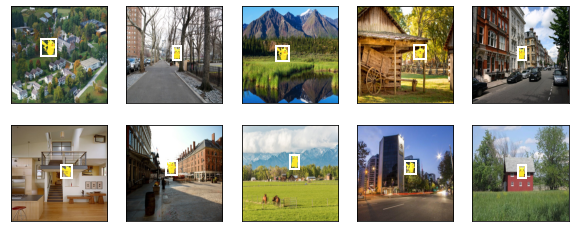

In [15]:
imgs = batch["image"][0:10].permute(0,2,3,1)
bboxes = batch["label"][0:10, 0, 1:]

axes = show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    show_bboxes(ax, [bb*edge_size], colors=['w'])

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import math
import torch
import numpy as np

In [17]:
def MultiBoxPrior(feature_map , size = [0.75,0.5,0.25],
                     rations = [1,2,0.5]):
    pairs = []
    for r in rations:
        pairs.append([size[0],math.sqrt(r)])
    for s in size[1:] :
        pairs.append([s,math.sqrt(rations[0])])
    
    pairs = np.array(pairs)
    ss1 = pairs[:,0] * pairs[:,1]
    ss2 = pairs[:,0] / pairs[:,1]
    
    base_anchors = np.stack([-ss1,-ss2,ss1,ss2],axis =1)/2
    #print(base_anchors.shape)
    h,w = feature_map.shape[-2:]
    shifts_x = np.arange(0,w)/w
    shifts_y = np.arange(0,h)/h
    shift_x,shift_y = np.meshgrid(shifts_x,shifts_y)
    
    #print(shift_x.shape,shift_y.shape)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x,shift_y,shift_x,shift_y),axis =1)
    #print(shifts.shape)
    anchors = shifts.reshape((-1,1,4))+base_anchors.reshape((1,-1,4))
    #print(anchors.shape)
    return torch.tensor(anchors,dtype=torch.float32).view(1,-1,4)

In [18]:
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

In [19]:
def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    """
    # 按照「9.4.1. 生成多个锚框」图9.3所讲为每个anchor分配真实的bb, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        bb: 真实边界框(bounding box), shape:（nb, 4）
        anchor: 待分配的anchor, shape:（na, 4）
        jaccard_threshold: 预先设定的阈值
    Returns:
        assigned_idx: shape: (na, ), 每个anchor分配的真实bb对应的索引, 若未分配任何bb则为-1
    """
    na = anchor.shape[0] 
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy() # shape: (na, nb)
    assigned_idx = np.ones(na) * -1  # 存放标签初始全为-1
    
    # 先为每个bb分配一个anchor(不要求满足jaccard_threshold)
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j])
        assigned_idx[i] = j
        jaccard_cp[i, :] = float("-inf") # 赋值为负无穷, 相当于去掉这一行
     
    # 处理还未被分配的anchor, 要求满足jaccard_threshold
    for i in range(na):
        if assigned_idx[i] == -1:
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j
                
    return torch.tensor(assigned_idx, dtype=torch.long)


def xy_to_cxcy(xy):
    """
    将(x_min, y_min, x_max, y_max)形式的anchor转换成(center_x, center_y, w, h)形式的.
    https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Args:
        xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    Returns: 
        bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

def MultiBoxTarget(anchor, label):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        anchor: torch tensor, 输入的锚框, 一般是通过MultiBoxPrior生成, shape:（1，锚框总数，4）
        label: 真实标签, shape为(bn, 每张图片最多的真实锚框数, 5)
               第二维中，如果给定图片没有这么多锚框, 可以先用-1填充空白, 最后一维中的元素为[类别标签, 四个坐标值]
    Returns:
        列表, [bbox_offset, bbox_mask, cls_labels]
        bbox_offset: 每个锚框的标注偏移量，形状为(bn，锚框总数*4)
        bbox_mask: 形状同bbox_offset, 每个锚框的掩码, 一一对应上面的偏移量, 负类锚框(背景)对应的掩码均为0, 正类锚框的掩码均为1
        cls_labels: 每个锚框的标注类别, 其中0表示为背景, 形状为(bn，锚框总数)
    """
    assert len(anchor.shape) == 3 and len(label.shape) == 3
    bn = label.shape[0]
    
    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        """
        MultiBoxTarget函数的辅助函数, 处理batch中的一个
        Args:
            anc: shape of (锚框总数, 4)
            lab: shape of (真实锚框数, 5), 5代表[类别标签, 四个坐标值]
            eps: 一个极小值, 防止log0
        Returns:
            offset: (锚框总数*4, )
            bbox_mask: (锚框总数*4, ), 0代表背景, 1代表非背景
            cls_labels: (锚框总数, 4), 0代表背景
        """
        an = anc.shape[0]
        # 变量的意义
        assigned_idx = assign_anchor(lab[:, 1:], anc) # (锚框总数, )
        #print("a: ",  assigned_idx.shape)
        #print(assigned_idx)
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4) # (锚框总数, 4)
        #print("b: " , bbox_mask.shape)
        #print(bbox_mask)

        cls_labels = torch.zeros(an, dtype=torch.long) # 0表示背景
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32) # 所有anchor对应的bb坐标
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0: # 即非背景
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1 # 注意要加一
                assigned_bb[i, :] = lab[bb_idx, 1:]
        # 如何计算偏移量
        center_anc = xy_to_cxcy(anc) # (center_x, center_y, w, h)
        center_assigned_bb = xy_to_cxcy(assigned_bb)

        offset_xy = 10.0 * (center_assigned_bb[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * torch.log(eps + center_assigned_bb[:, 2:] / center_anc[:, 2:])
        offset = torch.cat([offset_xy, offset_wh], dim = 1) * bbox_mask # (锚框总数, 4)

        return offset.view(-1), bbox_mask.view(-1), cls_labels
    # 组合输出
    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_labels = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])
        
        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)
    
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)
    
    return [bbox_offset, bbox_mask, cls_labels]

In [20]:
from collections import namedtuple
Pred_BB_Info = namedtuple("Pred_BB_Info", ["index", "class_id", "confidence", "xyxy"])

def non_max_suppression(bb_info_list, nms_threshold = 0.5):
    """
    非极大抑制处理预测的边界框
    Args:
        bb_info_list: Pred_BB_Info的列表, 包含预测类别、置信度等信息
        nms_threshold: 阈值
    Returns:
        output: Pred_BB_Info的列表, 只保留过滤后的边界框信息
    """
    output = []
    # 先根据置信度从高到低排序
    sorted_bb_info_list = sorted(bb_info_list, key = lambda x: x.confidence, reverse=True)
    
    # 循环遍历删除冗余输出
    while len(sorted_bb_info_list) != 0:
        best = sorted_bb_info_list.pop(0)
        output.append(best)
        
        if len(sorted_bb_info_list) == 0:
            break

        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)
        
        iou = compute_jaccard(torch.tensor([best.xyxy]), 
                              torch.tensor(bb_xyxy))[0] # shape: (len(sorted_bb_info_list), )
        
        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
    return output

def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold = 0.5):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        cls_prob: 经过softmax后得到的各个锚框的预测概率, shape:(bn, 预测总类别数+1, 锚框个数)
        loc_pred: 预测的各个锚框的偏移量, shape:(bn, 锚框个数*4)
        anchor: MultiBoxPrior输出的默认锚框, shape: (1, 锚框个数, 4)
        nms_threshold: 非极大抑制中的阈值
    Returns:
        所有锚框的信息, shape: (bn, 锚框个数, 6)
        每个锚框信息由[class_id, confidence, xmin, ymin, xmax, ymax]表示
        class_id=-1 表示背景或在非极大值抑制中被移除了
    """
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3
    bn = cls_prob.shape[0]
    
    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold = 0.5):
        """
        MultiBoxDetection的辅助函数, 处理batch中的一个
        Args:
            c_p: (预测总类别数+1, 锚框个数)
            l_p: (锚框个数*4, )
            anc: (锚框个数, 4)
            nms_threshold: 非极大抑制中的阈值
        Return:
            output: (锚框个数, 6)
        """
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy() # 加上偏移量
        
        confidence, class_id = torch.max(c_p, 0)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()
        
        pred_bb_info = [Pred_BB_Info(
                            index = i,
                            class_id = class_id[i] - 1, # 正类label从0开始
                            confidence = confidence[i],
                            xyxy=[*anc[i]]) # xyxy是个列表
                        for i in range(pred_bb_num)]
        
        # 正类的index
        obj_bb_idx = [bb.index for bb in non_max_suppression(pred_bb_info, nms_threshold)]
        
        output = []
        for bb in pred_bb_info:
            output.append([
                (bb.class_id if bb.index in obj_bb_idx else -1.0),
                bb.confidence,
                *bb.xyxy
            ])
            
        return torch.tensor(output) # shape: (锚框个数, 6)
    
    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))
    
    return torch.stack(batch_output)

In [21]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
import numpy as np
import sys

In [22]:
def cls_predictor(in_channels,num_anchors, num_classes):
    return nn.Conv2d(in_channels,num_anchors*(num_classes+1),kernel_size = 3, padding=1)

In [23]:
def bbox_preditor(in_channels,num_anchors):
    return nn.Conv2d(in_channels,num_anchors *4 , kernel_size = 3, padding =1)

In [24]:
def flatten(x):
    return  x.contiguous().view(x.shape[0], -1)

def flatten_pred(pred):
    return flatten(pred.permute((0,2,3,1)))

def concat_preds(preds):
    
    return torch.cat([flatten_pred(p) for p in preds],dim =1)


In [25]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2,8,20,20)),cls_predictor(8,5,10))
Y2 = forward(torch.zeros((2,16,10,10)),cls_predictor(16,3,10))
print(Y1.shape, Y2.shape)
concat_preds([Y1,Y2]).shape

torch.Size([2, 55, 20, 20]) torch.Size([2, 33, 10, 10])


torch.Size([2, 25300])

In [26]:
def down_sample_blk(in_channels,num_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels,num_channels,kernel_size=3 , padding = 1))
        blk.append(nn.BatchNorm2d(num_channels))
        blk.append(nn.ReLU())
        in_channels = num_channels
    blk.append(nn.MaxPool2d(kernel_size=3, stride=2,padding =1))
    return nn.Sequential(*blk)

In [27]:
forward(torch.zeros((2,3,20,20)),down_sample_blk(3,10)).shape

torch.Size([2, 10, 10, 10])

In [28]:
def base_net():
    blk = []
    in_channels = 3
    for num_filters in [16,32,64]:
        blk.append(down_sample_blk(in_channels,num_filters))
        in_channels = num_filters
    return nn.Sequential(*blk)

In [29]:
forward(torch.zeros((2,3,256,256)),base_net()).shape

torch.Size([2, 64, 32, 32])

In [30]:
class GlobalMaxpool2D(nn.Module):
    def __init__(self):
        super(GlobalMaxpool2D,self).__init__()
    def forward(self,x):
        return F.max_pool2d(x, kernel_size=x.size()[2:])

In [31]:
def get_blk(i):
    if i ==0 :
        blk = base_net()
    elif i == 4 :
        blk = GlobalMaxpool2D()
    elif i ==1:
        blk = down_sample_blk(64,128)
    else :
        blk = down_sample_blk(128,128)
    return blk

In [32]:
def blk_forward(X, blk, size , ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = MultiBoxPrior(Y, size = size , rations = ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [33]:
sizes = [[0.2,0.272],[0.37,0.337],[0.54,0.619],[0.71,0.79],[0.88,0.961]]
ratios = [[1,2,0.5]]*5
num_anchors = len(sizes[0])+len(ratios[0])-1

In [34]:
class TinySSD(nn.Module):
    def __init__(self, num_classes):
        super(TinySSD,self).__init__()
        self.num_classes = num_classes
        for i in range(5):
            setattr(self, "blk_%d"%i, get_blk(i))
            
            if i ==0 :
                in_channels = 64
            else:
                in_channels = 128
            setattr(self, "cls_%d"%i, cls_predictor(in_channels,num_anchors,num_classes))
            setattr(self, "bbox_%d"%i, bbox_preditor(in_channels, num_anchors))
    
    def forward(self,X):
        anchors, cls_preds, bbox_preds = [None]*5,[None]*5,[None]*5
        for i in range(5):
            X, anchors[i], cls_preds[i],bbox_preds[i] = blk_forward(X, getattr(self,'blk_%d'%i),sizes[i],
                                                                    ratios[i],getattr(self,"cls_%d"%i),
                                                                    getattr(self,'bbox_%d'%i))
        return (torch.cat(anchors, dim=1),
                concat_preds(cls_preds).view(X.shape[0],-1,self.num_classes+1),
                concat_preds(bbox_preds))

In [35]:
net = TinySSD(num_classes =1)
X = torch.zeros((32,3,256,256))
anchors,cls_preds, bbox_preds = net(X)

print(anchors.shape)
print(cls_preds.shape)
print(bbox_preds.shape)

torch.Size([1, 5444, 4])
torch.Size([32, 5444, 2])
torch.Size([32, 21776])


In [36]:
batch_size = 32
train_iter,val_iter = load_data_pikachu(batch_size)

In [37]:
net = TinySSD(num_classes =1)
trainer = torch.optim.SGD(net.parameters(),lr = 0.2, weight_decay = 5e-4)

In [38]:
cls_loss = torch.nn.CrossEntropyLoss()
bbox_loss = torch.nn.L1Loss()
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds* bbox_masks,bbox_labels * bbox_masks)
    return cls + bbox

In [39]:
def cls_eval(cls_preds, cls_labels):
    cls_labels = cls_labels.long()
    return torch.sum((torch.argmax(cls_preds, dim=-1) == cls_labels))

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds)* bbox_masks).abs().sum()

In [40]:
def train(num_epoch):
    for epoch in range(num_epoch):
        acc_sum, mae_sum, n, m =0.0,0.0,0,0
        start = time.time()
        for batch in train_iter:
            X = batch["image"]
            Y = batch['label']
            anchors, cls_preds,bbox_preds = net(X)
            #print(anchors.shape,cls_preds.shape,Y.shape)
            bbox_labels,bbox_masks,cls_labels = MultiBoxTarget(anchors,Y)
            #print(cls_labels.shape)
            l = calc_loss(cls_preds.permute((0,2,1)), cls_labels,bbox_preds, bbox_labels, bbox_masks)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            acc_sum += cls_eval(cls_preds, cls_labels)
            #print(len(cls_labels))
            n+= len(cls_labels)
            mae_sum += bbox_eval(bbox_preds,bbox_labels, bbox_masks)
            m+= len(bbox_labels)
        if(epoch+1)%5 ==0:
            print('epoch %2d, class err%.2e, bbox mae%.2e, time%.1f sec'%(epoch+1, 1-acc_sum/n,mae_sum/m,time.time()-start))
    torch.save(net.state_dict(),data/SSD.pth)

In [ ]:
train(20)

In [46]:
batch = iter(val_iter).next()
X = batch['image'][0]
X = torch.unsqueeze(X,0)
print(X.shape)

torch.Size([1, 3, 256, 256])


In [56]:
def predict(X):
    anchors, cls_preds,bbox_preds = net(X)
    m = torch.nn.Softmax(dim=-1)
    print(cls_preds.shape,bbox_preds.shape)
    cls_probs = m(cls_preds).permute((0,2,1)).contiguous()
    output = MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i ,row in enumerate(output[0]) if row[0]!=-1]
    return output[0,idx]

In [57]:
output = predict(X)

torch.Size([1, 5444, 2]) torch.Size([1, 21776])


IndexError: slice() cannot be applied to a 0-dim tensor.